In [28]:
# TODO add utils (for like IO / data handling) specific to melody generation

from enum import Enum
from os import walk, listdir
import os.path

from tqdm import tqdm
from music21.note import Note, Rest
from music21.pitch import Pitch
from music21.duration import Duration
from music21.tempo import MetronomeMark


class Columns(Enum):
    Sira = 0
    Kod = 1
    Nota53 = 2
    NotaAE = 3
    Koma53 = 4
    KomaAE = 5
    Pay = 6
    Payda = 7
    Ms = 8
    LNS = 9
    Bas = 10
    Soz1 = 11
    Offset = 12


CODE_NOTE = 9
CODE_REST = "Es"
OneCommaInCents = 21.51 # according to Wikipedia

SYMBTR_TXT_FOLDER = "/Users/sercanatli/Workspaces/SymbTr/txt"

def parse_symbtr_txt(filename):
    '''Parses given symbtr, returns music21 (Note, Duration)'''

    note_list = []
    # tempo (can be used later)
    bpm = None
    
    file = open(filename)
    for index, line in enumerate(file):
        if (index == 0):
            continue

        split_line = line.strip().split("\t")

        # time signature
        ts_num=None
        ts_denum=None
        if (index == 1):
            ts_num = int(split_line[Columns.Pay.value])
            ts_denum = int(split_line[Columns.Payda.value])

        # reading notes
        if (int(split_line[Columns.Kod.value])) == CODE_NOTE:
            parsed_note = split_line[Columns.NotaAE.value]
    
            # note name
            note_name = parsed_note[:2]
            accidental = None
    
            if (len(parsed_note) > 2):
                parsed_note_for_accidental = split_line[Columns.Nota53.value]
                accidental = parsed_note_for_accidental[-2:]        
    
            # note length
            pay = int(split_line[Columns.Pay.value])
            payda = int(split_line[Columns.Payda.value])

            if pay == 1 and payda == 4 and bpm == None:
                bpm = 60000 / int(split_line[Columns.Ms.value])
                print("bpm:", bpm)
                
            # calculate microtone
            if (accidental):
                signature = 1 if accidental[0] == "#" else -1
                microtone = signature * int(accidental[1]) * OneCommaInCents

            if (parsed_note == CODE_REST):
                note = Rest()
            else:
                note = Pitch(step=parsed_note[0], 
                             octave=int(parsed_note[1]),
                             accidental=None,
                             microtone=microtone if accidental else None)

            duration = Duration()
            duration.quarterLength = (pay/payda) / (1/4)
            note_list.append((note, duration))
    file.close()
    
    return note_list


def get_training_data(makam):
    training_data = []
    scores = [symbtr for symbtr in listdir(SYMBTR_TXT_FOLDER) if symbtr.split("--")[0] == makam]
    states = set()

    composition_count = 0
    note_count = 0
    
    for score_file in tqdm(scores):
        scores = parse_symbtr_txt(os.path.join(SYMBTR_TXT_FOLDER, score_file))
        training_data.append(parse_symbtr_txt(os.path.join(SYMBTR_TXT_FOLDER, score_file)))

    return training_data



 14%|██████████████████████▊                                                                                                                                                | 9/66 [00:00<00:00, 85.22it/s]

bpm: 60.0
bpm: 60.0
bpm: 78.02340702210664
bpm: 78.02340702210664
bpm: 54.005400540054005
bpm: 54.005400540054005
bpm: 60.0
bpm: 60.0
bpm: 60.0
bpm: 60.0
bpm: 102.04081632653062
bpm: 102.04081632653062
bpm: 72.02881152460985
bpm: 72.02881152460985
bpm: 66.00660066006601
bpm: 66.00660066006601
bpm: 78.02340702210664
bpm: 78.02340702210664
bpm: 78.02340702210664
bpm: 78.02340702210664
bpm: 78.02340702210664
bpm: 78.02340702210664
bpm: 102.04081632653062
bpm: 102.04081632653062
bpm: 78.02340702210664
bpm: 78.02340702210664
bpm: 66.00660066006601
bpm: 66.00660066006601
bpm: 72.02881152460985
bpm: 72.02881152460985
bpm: 78.02340702210664
bpm: 78.02340702210664
bpm: 68.96551724137932
bpm: 68.96551724137932
bpm: 66.00660066006601
bpm: 66.00660066006601
bpm: 72.02881152460985
bpm: 72.02881152460985
bpm: 60.0
bpm: 60.0
bpm: 51.02040816326531
bpm: 51.02040816326531
bpm: 66.00660066006601
bpm: 66.00660066006601
bpm: 96.0
bpm: 96.0
bpm: 84.03361344537815
bpm: 84.03361344537815
bpm: 89.955022488755

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 228.70it/s]


bpm: 66.00660066006601
bpm: 66.00660066006601
bpm: 63.02521008403362
bpm: 63.02521008403362
bpm: 114.06844106463879
bpm: 114.06844106463879
bpm: 66.00660066006601
bpm: 66.00660066006601
bpm: 89.95502248875562
bpm: 89.95502248875562
bpm: 54.005400540054005
bpm: 54.005400540054005
bpm: 66.00660066006601
bpm: 66.00660066006601
bpm: 54.005400540054005
bpm: 54.005400540054005
bpm: 78.02340702210664
bpm: 78.02340702210664
bpm: 54.005400540054005
bpm: 54.005400540054005
bpm: 126.05042016806723
bpm: 126.05042016806723
bpm: 56.98005698005698
bpm: 56.98005698005698
bpm: 78.02340702210664
bpm: 78.02340702210664
bpm: 70.01166861143524
bpm: 70.01166861143524
bpm: 84.03361344537815
bpm: 84.03361344537815
bpm: 60.0
bpm: 60.0
bpm: 60.0
bpm: 60.0
bpm: 86.95652173913044
bpm: 86.95652173913044
bpm: 78.02340702210664
bpm: 78.02340702210664
bpm: 60.0
bpm: 60.0
bpm: 54.005400540054005
bpm: 54.005400540054005
bpm: 72.02881152460985
bpm: 72.02881152460985
bpm: 72.02881152460985
bpm: 72.02881152460985
bpm: 66.

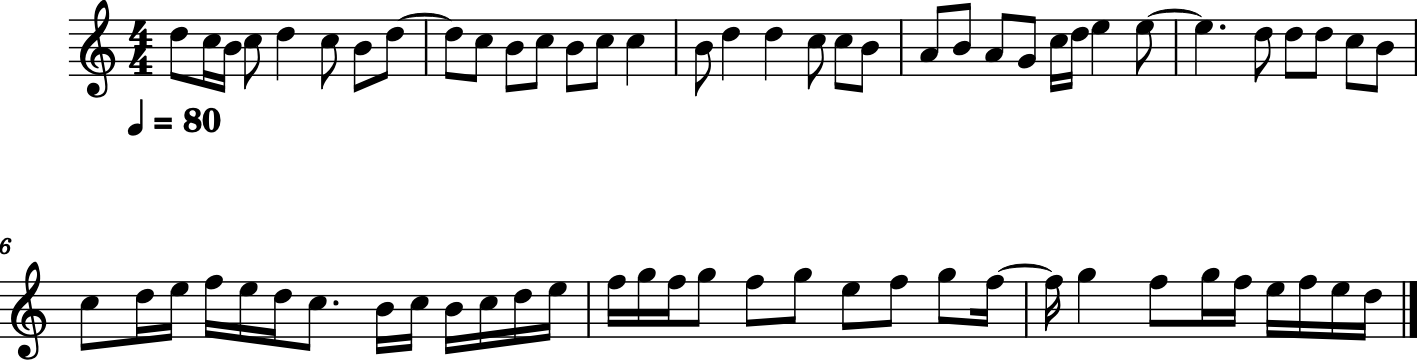

CPU times: user 585 ms, sys: 54.6 ms, total: 640 ms
Wall time: 2.51 s


'/Users/sercanatli/Desktop/output_generated.mid'

In [29]:
%%time
from simplemelodygen.extensions import MultiInstanceTrainableMarkovChainMelodyGenerator

tempo_mark = MetronomeMark(number=80)

training_data=[]
states = set()
saba_pitches = set()

# you can change the name of makam to get training data
# list of lists containing music21 notes
saba_data = get_training_data("saba")
for composition in saba_data:
    note_list = []
    note = None

    for pitch, duration in composition:
        if (pitch.name == "rest"):
            note = Rest(duration=duration)
        else:
            note = Note(pitch, duration=duration)
        note_list.append(note)
    training_data.append(note_list)


# TODO! put the logic somewhere else to generate states
for composition in saba_data:
    for note_pair in composition:
        saba_pitches.add(note_pair[0])
        states.add((note_pair[0].nameWithOctave if note_pair[0].name != "rest" else "Rest", note_pair[1].quarterLength))


model = MultiInstanceTrainableMarkovChainMelodyGenerator(list(states))
model.train(training_data)

saba_melody, _ = model.generate(64)

from music21 import stream

score = stream.Score()
part = stream.Part()

# fix this loop here! something is wrong
for note in saba_melody:
    for pitch in list(saba_pitches):
        if pitch.name == "rest":
            continue
        elif note[0] == "Rest":
            part.append(Rest(note[1]))
            break
        elif note[0] == pitch.nameWithOctave:
            print(pitch)
            part.append(Note(pitch, quarterLength=note[1]))
            break

# Insert the tempo mark at the beginning of the part
part.insert(0, tempo_mark)

score.append(part)
score.show('midi')
score.show()

output_path = "/Users/sercanatli/Desktop/output_generated.mid"
score.write('midi', fp=output_path)

bpm: 72.02881152460985


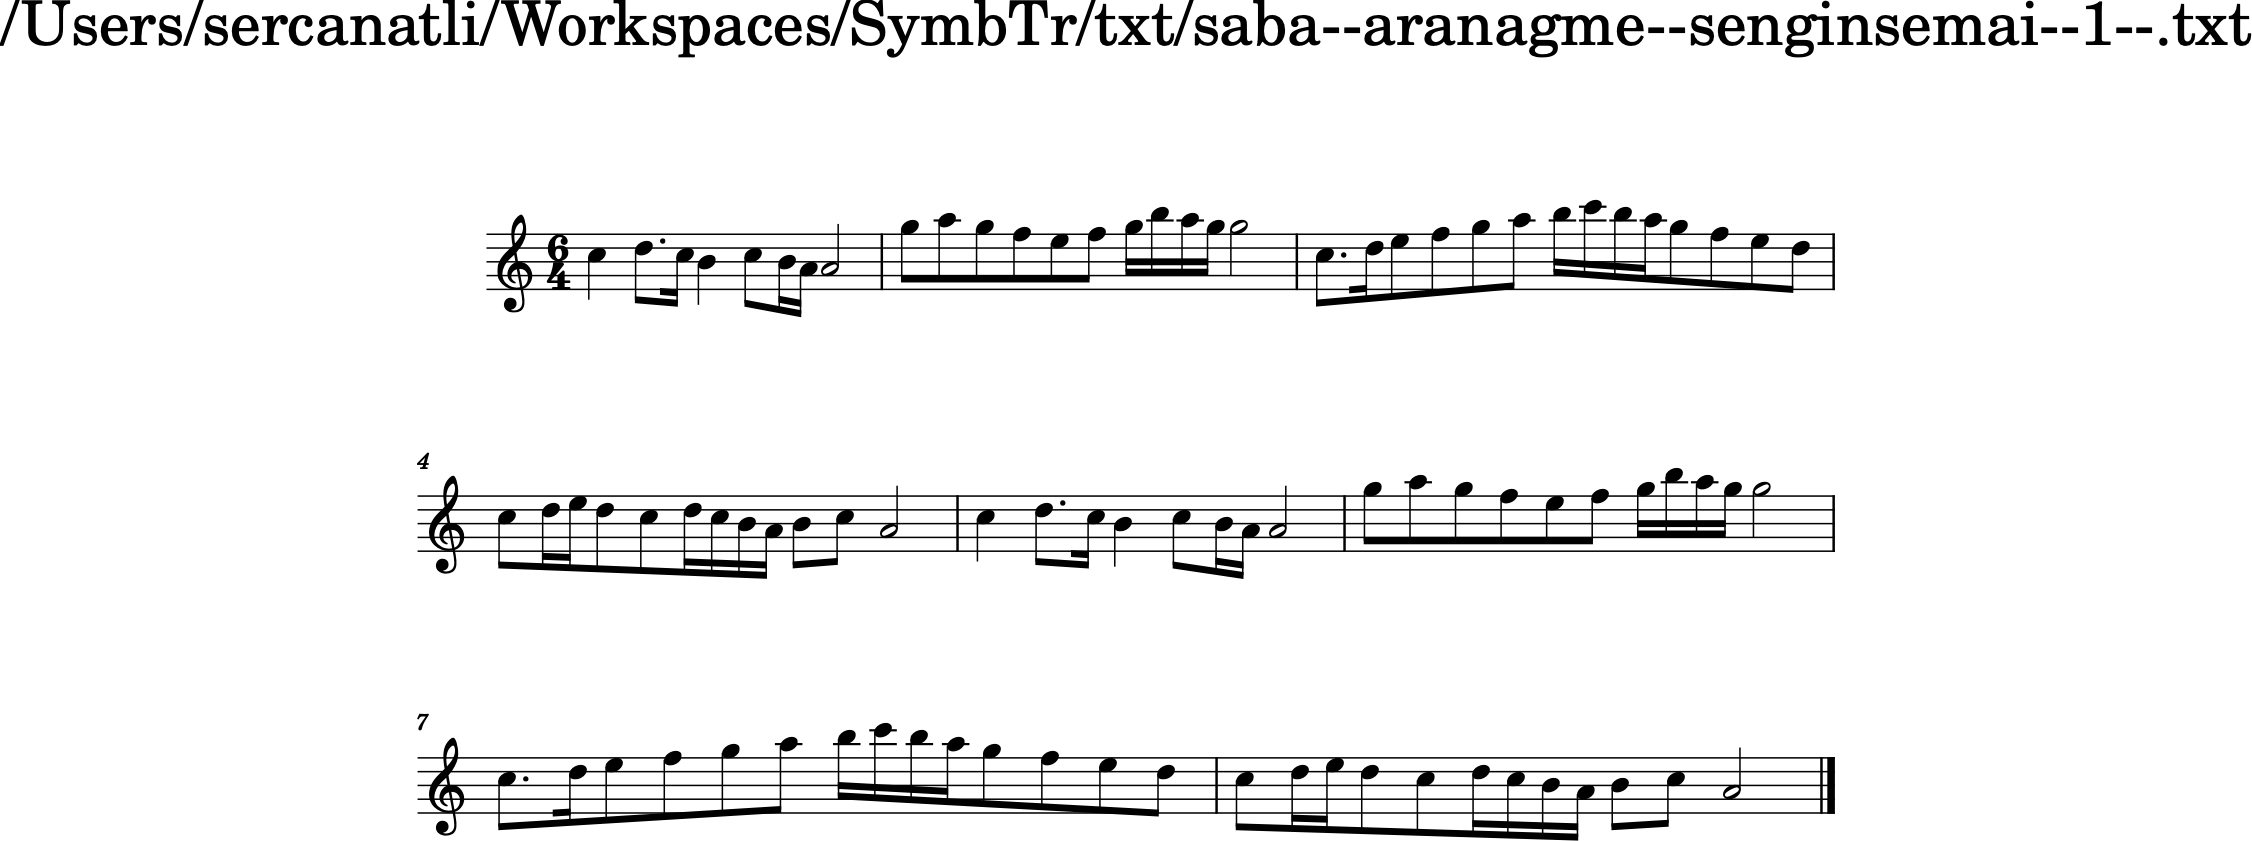

In [30]:
from music21 import metadata, note, stream, meter

symbtr_path = "/Users/sercanatli/Workspaces/SymbTr/txt/saba--aranagme--senginsemai--1--.txt"
melody = parse_symbtr_txt(symbtr_path)

score = stream.Score()
score.metadata = metadata.Metadata(title=symbtr_path)
part = stream.Part()

ts0 = meter.TimeSignature('6/4')

part.append(ts0)
for pitch, duration in melody:
    if (pitch.name == "rest"):
        part.append(Rest(duration=duration))
    else:
        part.append(Note(pitch, duration=duration))

score.append(part)
score.show('midi')
score.show()